In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from Baseline import generateReservoir, generateTopologyInput, assignWeightsReservoir, assignWeightsInputs
from Baseline import simulacionBrianStates, simulacionBrian2Voltages
from Data import TIDIGITS, FSDD
from eBallena import eBallena
from Utils import fastEval

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [8]:
# ======================
#     LOAD DATASET
# ======================
""" 
La configuracion del dataset fue tuneada en otro notebook
Pero la idea es que esta configuracion es relativamente optima
"""
fsdd = FSDD(time_bin=80, max_spikes=10, n_dim=26,  hop_lenght=400, random_state=88)


Cantidad de spikes: [7]


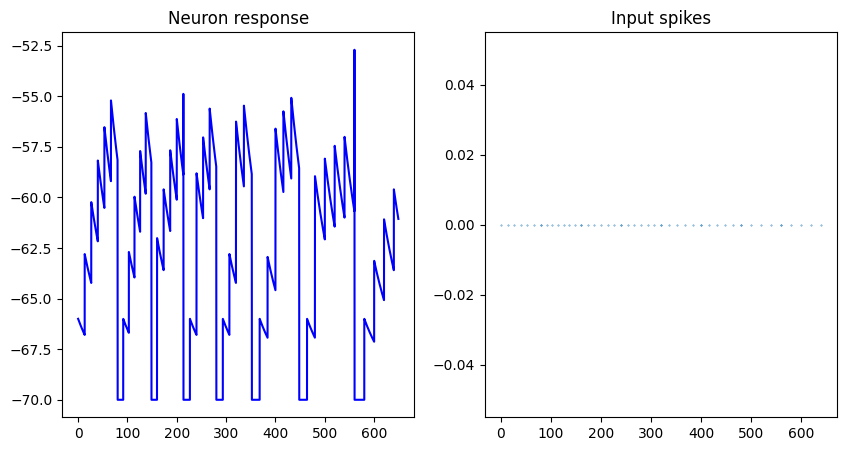

In [49]:
# ===============================
#  ANALISIS A NIVEL DE NEURONA
# ===============================
""" 
Aqui veremos la configuracion para el modelo LIF. Se tunearán el tau y los pesos de los inputs.
El objetivo es comprobar que dados los inputs del dataset (con su respectivo spike rate),
las neuronas tendran una cantidad de spikes razonable. ¿Que es razonable? Si durante toda la simulacion
se activan 4~10 parece razonable. Menos de eso es muy poco y mas de eso es demasiado.
Obviamente todo esto es "al ojo". En este notebook no hay optimizacion. 
"""

# ================
# HIPERPARAMETROS
tau    	   = 60
weight_in  = 4
refractory = 5
instance   = 11

# ==========================
# SELECCIONO UN SOLO INPUT 
# Y UNA SOLA NEURONA
syn_in = [(0,0,weight_in)]
instance = np.array(fsdd.d_train[instance])
channel0  = instance[ instance[:,1]==0 ][:,0].round(2)
channel0  = [ (time,0) for time in channel0 ]

# ==============
# CONFIGURACION
config = eBallena.createConfig(n_inputs=1, n_neu=1, tau=tau, max_sim_time=3_000, refractory_time=refractory, threshold=-55)


# ==============
#  SIMULACION
volt = eBallena.simulate( config, channel0, syn_in, [], mode='VOLTAGES' )
spk  = eBallena.simulate( config, channel0, syn_in, [], mode='STATE' )


# ==============
#      PLOT

print('Cantidad de spikes:',spk)

plt.figure( figsize=(10,5) )
plt.subplot(121)
plt.title('Neuron response')
eBallena.plotVoltage( volt, 0, config )
plt.subplot(122)
plt.title('Input spikes')
plt.scatter( np.array(channel0)[:,0],np.array(channel0)[:,1], s=0.1 )
plt.show()

In [50]:
# ======================
#    TUNNING INPUTS
# ======================
""" 
Aqui asignamos una probabilidad de conexions input-reservoir y unos pesos synapticos para el input. 
El objetivo es comprobar visualmente que la red "no explota".
Tambien se puede comentar la linea 15 y cambiar el numero de instancia para comprobar que distintas instancias 
tienen una respuesta distintas por parte de la red
"""

# ================
# HIPERPARAMETROS
prob_connection = 0.03
instance   = 6

connections_in, syn_type = generateTopologyInput(26,1000,prob_connection=prob_connection)
syn_in = assignWeightsInputs(connections_in, syn_type, weight_in )

config = eBallena.createConfig(n_inputs=26, n_neu=1000, tau=tau, max_sim_time=3_000, refractory_time=refractory, threshold=-55)
num_spikes = eBallena.simulate( config, fsdd.d_train[instance], syn_in, [], mode='STATE' )
print('Cantidad de spikes', num_spikes.sum())
num_spikes


Cantidad de spikes 1120


array([ 0,  0,  5,  0,  3,  3,  0,  0,  0,  0,  3, 10,  0,  1,  0,  0,  3,
        0,  6,  0,  3,  3,  0,  7,  0,  0,  4,  0,  3,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  4,  0,  3,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  7, 10,  0,  0,  0,  2,  0,  0,  0,  0,
        4,  0,  0,  0,  0,  0,  0,  0,  1,  3,  0,  5,  0,  7,  0,  0,  0,
        0,  7,  0, 10,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  5,  0,  0,  0,  0,  0,  0,  4,
        0,  3,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  3,  0,
        0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  3,  0,  0,  1,  0,  3,  0,  0,  7,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  1,  4, 14,  0,
        0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  7,  0,  0,
        6,  5, 17,  0,  0

In [51]:
# ======================
#   TESTING ACCURACY
#   ONLY WITH INPUTS
# ======================
""" 
En esta parte mido el accuracy usando solo la capa de entrada, sin conexiones internas.
La idea es tratar de maximar este valor inicial con una buen capa de entrada. Para eso se puede modificar
la probabilidad de conexion y en la celda anterior.
"""

states_train = []
for instance in tqdm(fsdd.d_train):
    states_train.append( eBallena.simulate( config, instance, syn_in, [], mode='STATE' )  )
states_train = np.array(states_train)

states_test = []
for instance in tqdm(fsdd.d_test):
    states_test.append( eBallena.simulate( config, instance, syn_in, [], mode='STATE' )  )
states_test = np.array(states_test)

acc_linear = fastEval(states_train, states_test, fsdd.t_train, fsdd.t_test, 'linear')
acc_forest = fastEval(states_train, states_test, fsdd.t_train, fsdd.t_test, 'random_forest')
print('Usando logisticRegresion: Accuracy solo con inputs: (test/train)', np.array(acc_linear).round(2))
print('Usando randomForest     : Accuracy solo con inputs: (test/train)', np.array(acc_forest).round(2))

100%|██████████| 600/600 [00:06<00:00, 95.23it/s] 


Usando logisticRegresion: Accuracy solo con inputs: (test/train) [0.83 0.92]
Usando randomForest     : Accuracy solo con inputs: (test/train) [0.91 1.  ]


In [52]:
# ======================
#  GENERATE CONNECTIONS
#     IN RESERVOIR
# ======================
""" 
En este punto tenemos listo el modelo LIF y la capa de entrada. Falta empezar con el reservoir.
Estas conexiones son fijas segun el modelo. Se generan 1 vez porque ademas se demora un buen tiempo en generar.
"""
connections_re, neuron_type = generateReservoir(prob_exitatory=0.8)

In [54]:
# =============================
# ASSIGN WEIGHTS TO RESERVOIR
# =============================
""" 
En este punto asigno el peso synaptico al reservoir. Solo estoy midiendo la cantidad de spikes que se generan.
El objetivo es que la red no explote. Que solo haya unos pocos spikes extra debido a las conexiones del reservoir.
Como valores de referencia, 100~400 spikes extra son razonables y no realentizan tanto la simulacion.
"""
weights_re = 2.1
instance   = 0

syn_re = assignWeightsReservoir( connections_re,neuron_type, weights_re )
config = eBallena.createConfig(n_inputs=26, n_neu=1000, tau=tau, max_sim_time=3_000, refractory_time=refractory, threshold=-55)
n_spikes_inicial   = eBallena.simulate( config, fsdd.d_train[instance], syn_in, [], mode='STATE' ).sum()
n_spikes_reservoir = eBallena.simulate( config, fsdd.d_train[instance], syn_in, syn_re, mode='STATE' ).sum()

print('Cantidad total de spikes', n_spikes_reservoir)
print('De los cuales',n_spikes_reservoir-n_spikes_inicial, 'se deben a las conexiones internas')

Cantidad total de spikes 2771
De los cuales 1773 se deben a las conexiones internas


In [55]:
# ======================
#    TESTING FINAL
#     ACCURACY
# ======================

states_train = []
for instance in tqdm(fsdd.d_train):
    states_train.append( eBallena.simulate( config, instance, syn_in, syn_re, mode='STATE' )  )
states_train = np.array(states_train)

states_test = []
for instance in tqdm(fsdd.d_test):
    states_test.append( eBallena.simulate( config, instance, syn_in, syn_re, mode='STATE' )  )
states_test = np.array(states_test)


acc_linear = fastEval(states_train, states_test, fsdd.t_train, fsdd.t_test, 'linear')
acc_forest = fastEval(states_train, states_test, fsdd.t_train, fsdd.t_test, 'random_forest')
print('Usando logisticRegresion: Accuracy: (test/train)', np.array(acc_linear).round(2))
print('Usando randomForest     : Accuracy: (test/train)', np.array(acc_forest).round(2))

100%|██████████| 600/600 [00:22<00:00, 26.13it/s]


Usando logisticRegresion: Accuracy: (test/train) [0.85 1.  ]
Usando randomForest     : Accuracy: (test/train) [0.88 1.  ]


In [ ]:
# ======================
#   BRIAN2 COMPARISON
# ======================

config = eBallena.createConfig(n_inputs=26, n_neu=1000, tau=40, max_sim_time=1_100, refractory_time=refractory, threshold=-55)

states_test = simulacionBrianStates(config, fsdd.d_test, syn_in, syn_re)